# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Description](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>
### 1.1. Background

With a population of more than 2,693,976, Chicago, Illinois, USA, is the third-largest city in the USA. With the highly developed and diversified economy, Chicago is a very attractive city for people looking for work or to start their own business, including small businesses such as coffee shops, bakeries, and restaurants. This also makes entry into the market very competitive. For someone, for example, opening a bakery, choosing the right location for the shop can make or break the business.

### 1.2. Problem
How someone who wants to open for example a bakery should choose the right location? One would argue that close proximity to the exits from the interstate roads might be a good choice since majority of inhabitants of Howard County is using them for daily commute to their work, so it will make business position in such a location very convenient to stop by. However, Covid-19 and work from home phenomenon dramatically changed people’s daily routines, so location near interstate exit may not be a good choice. It will be useful to conduct geo-location analysis to possibly find pattern and understand which location might be more popular than other. 

### 1.3. Interest
For purpose of this exercise, I’ll will do the analysis and try to predict the best spot to open a bakery. Therefore, this research might be of interest to somebody who wants to open a bakery and needs to know which location might be the best to open such a business.

## 2. Data Description <a name="data"></a>

For the analysis I’ll use **Foursquare API** to get most popular venues in Howard County. Also, I’ll check the location of current bakeries and bakeries within grocery stores.

I'll divide Chicago into communities by using the zip codes of Chicago. This data set can be found on [zipatlas.com](http://zipatlas.com/us/il/chicago/zip-code-comparison/population-density.htm); this data set also has population numbers by zip code. I'll remove communities with less than 3,000 on the assumption that opening a bakery in this area will not be suitable since foot traffic is insufficient for business to sustain.

Since zipatlas.com data set has only zip codes with no latitude and longitude, I'll use [OpenDataSoft](https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/?q=IL&refine.state=IL) to get longitude and latitude for each zip code.

To match community names to their zip code, I'll use [unitedstateszipcodes.org](https://www.unitedstateszipcodes.org/il/) data set that has zip codes with corresponding community names.


## 3. Methodology <a name="methodology"></a>

### 3.1. Preparing the Data: Zip Codes, Population, Location and Communities
First, we’ll get population by zip code in the state of Illinois. We’ll get this data from zapatlas.com. Some of the data we do not need so I removed unnecessary information. Also, I removed zip codes with less than 3000 inhabitants on basses that those communities will not be attractive for opening a bakery.

Next we’ll have to get community names that belong to each zip code as well as longitude and latitude per zip code. To achieve this we need to data sets one drop OpenDataSoft  and the other one from unitedstateszipcodes.org.

We’ll merge those data frames together with population data frame. The final data frame will conation zip codes, city and community names, population, longitude and latitude. We’ll drop communities that do not belong to the city of Chicago.

Finally, we’ll plot Chicago communities on the map using folium library.

In [209]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
print('Libraries imported.')

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium


from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


Get zip codes, population by zip code, and save them in the dataframe ```df_zip_codes```.

In [3]:
html_doc = requests.get('http://zipatlas.com/us/il/chicago/zip-code-comparison/population-density.htm')
try:
    html_doc.raise_for_status()
except Exception as exc:
    print(f'There was a problem: {exc}')
    
print('Ready')

soup = BeautifulSoup(html_doc.text, 'html.parser')

rows = soup.select('table[rules="all"] > tr')

df_rows = []

for i in range(len(rows)):
    row = rows[i].find_all(['th', 'td'])
    df_row =[]
    for td in row:
        try:
            df_row.append(td.text.replace('\n', ''))
        except:
            continue
    if len(df_row) > 0:
        df_rows.append(df_row)
        
df_zip_codes = pd.DataFrame(df_rows[1:], columns=df_rows[0])
df_zip_codes.head()

Ready


,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank
0,1.,60626,"42.009340, -87.669902","Chicago, Illinois","59,251","34,520.21",#98
1,2.,60660,"41.990561, -87.664706","Chicago, Illinois","47,726","34,193.05",#99
2,3.,60640,"41.972347, -87.663982","Chicago, Illinois","74,030","32,103.29",#109
3,4.,60657,"41.938964, -87.656811","Chicago, Illinois","66,789","31,204.02",#112
4,5.,60610,"41.900034, -87.636967","Chicago, Illinois","47,513","30,110.68",#119


In [4]:
df_zip_codes = df_zip_codes[['Zip Code', 'Population']]
df_zip_codes.head()

,Zip Code,Population
0,60626,"59,251"
1,60660,"47,726"
2,60640,"74,030"
3,60657,"66,789"
4,60610,"47,513"


In [5]:
df_zip_codes.shape

(55, 2)

Remove ',' from the Population and change data type to integer.

In [6]:
import re
df_zip_codes['Population'] = df_zip_codes['Population'].map(lambda x: re.sub('\D', '', x))
df_zip_codes['Population'] = df_zip_codes['Population'].map(int)
df_zip_codes.head()

,Zip Code,Population
0,60626,59251
1,60660,47726
2,60640,74030
3,60657,66789
4,60610,47513


Remove zip codes wiht population less than 3000.

In [8]:
df_zip_codes = df_zip_codes[df_zip_codes['Population'] > 3000]
df_zip_codes.shape

(50, 2)

Open CSV with all zip codes, latitude, longitude, and cities names in Illinoi, USA. Save data in data frame ```geopoint```.

In [9]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geopoint = pd.read_csv(body)
geopoint.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,61475,Sciota,IL,40.581413,-90.76120,-6,1,"40.581413, -90.7612"
1,62530,Divernon,IL,39.568077,-89.65467,-6,1,"39.568077, -89.65467"
2,62943,Grantsburg,IL,37.342538,-88.73381,-6,1,"37.342538, -88.73381"
3,61102,Rockford,IL,42.255170,-89.12970,-6,1,"42.25517, -89.1297"
4,61523,Chillicothe,IL,40.914377,-89.50654,-6,1,"40.914377, -89.50654"


Change the data type of Zip Code column in ```geopoint``` data frame to match data taype of the Zip Code in ```df_zip_codes``` data frame.

In [10]:
geopoint.rename(columns={"Zip": "Zip Code"}, inplace=True)
geopoint['Zip Code'] = geopoint['Zip Code'].map(str)

Merge ```df_zip_codes``` and ```geopoint``` data frames. The result data frame will have longitude and latitude for each zip code.

In [11]:
df_zip_codes = pd.merge(df_zip_codes, geopoint, on='Zip Code')
df_zip_codes.head()

,Zip Code,Population,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,60626,59251,Chicago,IL,42.009731,-87.66938,-6,1,"42.009731, -87.66938"
1,60660,47726,Chicago,IL,41.990631,-87.66670,-6,1,"41.990631, -87.6667"
2,60640,74030,Chicago,IL,41.973181,-87.66650,-6,1,"41.973181, -87.6665"
3,60657,66789,Chicago,IL,41.940832,-87.65852,-6,1,"41.940832, -87.65852"
4,60610,47513,Chicago,IL,41.898582,-87.63710,-6,1,"41.898582, -87.6371"


Open CSV file containing zip codes and community names in Chicago, IL.

In [12]:

body = client_c2efb76b4b6b42258510492597901f5f.get_object(Bucket='datasciencecourseracapstone-donotdelete-pr-woppyhzlezhae6',Key='chicago_zip_codes.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_communities = pd.read_csv(body)
df_communities.head()

,Zip Code,Community
0,60608,Lower West Side
1,60626,Rogers Park
2,60610,Uptown
3,60651,"Austin, Humboldt Park"
4,60646,Near North Side


Merge data frame with community name with ```df_zip_code```. New data frame will now have zip codes, community names, population and geolocation in single frame.

In [13]:
df_communities['Zip Code'] = df_communities['Zip Code'].map(str)
df_zip_codes= pd.merge(df_zip_codes, df_communities, on='Zip Code')
df_zip_codes.head()

,Zip Code,Population,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint,Community
0,60626,59251,Chicago,IL,42.009731,-87.66938,-6,1,"42.009731, -87.66938",Rogers Park
1,60660,47726,Chicago,IL,41.990631,-87.66670,-6,1,"41.990631, -87.6667",Edgewater
2,60640,74030,Chicago,IL,41.973181,-87.66650,-6,1,"41.973181, -87.6665",Uptown
3,60657,66789,Chicago,IL,41.940832,-87.65852,-6,1,"41.940832, -87.65852",Lake View
4,60610,47513,Chicago,IL,41.898582,-87.63710,-6,1,"41.898582, -87.6371",Uptown


Remove unecessery columns and rearange the colum order.

In [14]:
df_zip_codes.drop(['Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)
df_zip_codes = df_zip_codes[['Zip Code','Community','Population','City', 'State', 'Latitude', 'Longitude']]
df_zip_codes.head()

,Zip Code,Community,Population,City,State,Latitude,Longitude
0,60626,Rogers Park,59251,Chicago,IL,42.009731,-87.66938
1,60660,Edgewater,47726,Chicago,IL,41.990631,-87.66670
2,60640,Uptown,74030,Chicago,IL,41.973181,-87.66650
3,60657,Lake View,66789,Chicago,IL,41.940832,-87.65852
4,60610,Uptown,47513,Chicago,IL,41.898582,-87.63710


Place all zip code with community names on the map.

In [15]:
address = 'Chicago, Illinois'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Chicago, Illinois are {latitude}, {longitude}.')

The geograpical coordinate of Chicago, Illinois are 41.8755616, -87.6244212.


In [16]:
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)


for lat, lng, city, zip_code in zip(df_zip_codes['Latitude'], df_zip_codes['Longitude'], df_zip_codes['Community'], df_zip_codes['Zip Code']):
    label = f'{zip_code} {city}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### 3.2. Popular Venues and Population
Using Foursquare we’ll get the list of the most popular venue in the radius of 1500 meters. We’ll remove any duplicates that we may have due to the query overlap. Also, we need to merge venues data set with populations and community data frame.

There are 3,796 venues returned by Foursquare of those there are 52 bakeries in the city of Chicago. We’ll plot the bakeries on the map to get an idea how they are dispersed around the city.

**Define Forusquare credantials and version**

In [206]:
# Foursquare Credantials

Use Foursquare to get all venues in a 1500m radius using community coordinates.

In [111]:
def getNearbyVenues(names, people, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, people, lat, lng in zip(names, people, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            people,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community',
                             'Population',
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [112]:
chicago_venues = getNearbyVenues(names=df_zip_codes['Community'],
                                 people=df_zip_codes['Population'],
                                 latitudes=df_zip_codes['Latitude'], 
                                 longitudes=df_zip_codes['Longitude'])
chicago_venues.head()

Rogers Park
Edgewater
Uptown
Lake View
Uptown
Logan Square
Logan Square
North Park, Albany Park, Lincoln Square
Lincoln Park
Austin, Humboldt Park
Lake View
Belmont Cragin
Irving Park, North Center, Avondale
North Lawndale, South Lawndale
Grand Boulevard, Kenwood, Hyde Park, Washington Park
West Ridge
Portage Park, Irving Park
South Shore
Streeterville
West Town
New East Side
Austin
Grand Boulevard, Oakland, Kenwood
West Loop Gate
West Lawn, Chicago Lawn
Lower West Side
Near South Side, Douglas, 34 Armour Square
West Englewood
West Garfield Park, East Garfield Park
Humboldt Park
Englewood
Archer Heights, Brighton Park, West Elsdon, Gage Park
Chatham, Avalon Park, Burnside
Auburn Gresham, Washington Heights
Lincoln Park
Dunning
New City, McKinley Park, Bridgeport, 37 Fuller Park
Near West Side, East Garfield Park
Lincoln Square, North Park, Albany Park
Roseland, Pullman
Beverly
Norwood Park, Edison Park
O'Hare, Norwood Park
South Deering
Mount Greenwood, Beverly, Morgan Park
Near West S

,Community,Population,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,59251,42.009731,-87.66938,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,Rogers Park,59251,42.009731,-87.66938,Rogers Park Social,42.007360,-87.666265,Bar
2,Rogers Park,59251,42.009731,-87.66938,The Common Cup,42.007797,-87.667901,Coffee Shop
3,Rogers Park,59251,42.009731,-87.66938,Lifeline Theatre,42.007372,-87.666284,Theater
4,Rogers Park,59251,42.009731,-87.66938,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market


In [113]:
chicago_venues.shape

(3796, 8)

We have total of 3749 venues. Lets check how many wenues we have per community.

In [114]:
chicago_venues.groupby('Community').count()

,Population,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,,
"Archer Heights, Brighton Park, West Elsdon, Gage Park",86,86,86,86,86,86,86
"Auburn Gresham, Washington Heights",63,63,63,63,63,63,63
Austin,29,29,29,29,29,29,29
"Austin, Humboldt Park",64,64,64,64,64,64,64
Belmont Cragin,77,77,77,77,77,77,77
Beverly,34,34,34,34,34,34,34
"Chatham, Avalon Park, Burnside",59,59,59,59,59,59,59
Dunning,71,71,71,71,71,71,71
Edgewater,100,100,100,100,100,100,100


Lets see how many backeries we have in Chicago.

In [205]:
chicago_bakery = chicago_venues.copy()
chicago_bakery = chicago_bakery[chicago_venues['Venue Category'] == 'Bakery']
chicago_bakery.reset_index(drop=True, inplace=True)
chicago_bakery.shape

(52, 8)

In [120]:
chicago_bakery.head()

,Community,Population,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,59251,42.009731,-87.66938,Smack Dab,42.009291,-87.666201,Bakery
1,Rogers Park,59251,42.009731,-87.66938,Caribbean American Bakery,42.019371,-87.669705,Bakery
2,Edgewater,47726,41.990631,-87.66670,Lost Larson Bakery,41.978617,-87.668411,Bakery
3,Uptown,74030,41.973181,-87.66650,Lost Larson Bakery,41.978617,-87.668411,Bakery
4,Uptown,74030,41.973181,-87.66650,Chiu Quon Bakery,41.973256,-87.658906,Bakery


Let check to be sure we don't have duplicate bakeries in the ```chicago_bakery``` data frame. We'll remove all duplicates.

In [121]:
for i in chicago_bakery.index:
    j = i + 1
    if j <= chicago_bakery.index.stop:
        for j in range(j, chicago_bakery.index.stop):
            if (chicago_bakery.iloc[i]['Venue'] == chicago_bakery.iloc[j]['Venue']) and (chicago_bakery.iloc[i]['Venue Latitude'] == chicago_bakery.iloc[j]['Venue Latitude']) and (chicago_bakery.iloc[i]['Venue Longitude'] == chicago_bakery.iloc[j]['Venue Longitude']):
                chicago_bakery.loc[[j],['Venue']] = np.nan
            
chicago_bakery.dropna(inplace=True)
chicago_bakery.reset_index(inplace=True, drop = True)
chicago_bakery.shape

(48, 8)

According to Foursquare, there were 54 bakeries in Chicago. However, 4 were duplicates so the total number after cleaning the data set is 49 bakeries. Let us place them on the map.

In [122]:
map_chicago_bakery = folium.Map(location=[latitude, longitude], zoom_start=11)


for lat, lng, bakery, city, people in zip(chicago_bakery['Venue Latitude'], chicago_bakery['Venue Longitude'], chicago_bakery['Venue'], chicago_bakery['Community'], chicago_bakery['Population']):
    label = f'{bakery} | {city} | {people}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago_bakery)  
    
map_chicago_bakery

### 3.3. People per Bakery
Next, we’ll take a look at how many people each bakery may serve. We’ll create a new table that will group bakeries per community.

The minimum number of people that the bakery may serve is 8,349 (Lake View community) and a maximum of 85,771 (Auburn Gresham, Washington Heights). On the graph below we can see the relationship between number of bakeries per community and population per community. Lake View has 8 bakeries in total while there are 12 communities with only 1 bakery.

Let analyze ```chicago_bakery``` data set to understand the community population they serve.

In [198]:
chicago_bakery_count = chicago_bakery.groupby('Community').count()
chicago_bakery_count.reset_index(inplace=True)

chicago_bakery_count = chicago_bakery_count[['Community', 'Venue']].join(chicago_bakery[['Community', 'Population']].set_index('Community'), on='Community')
chicago_bakery_count = chicago_bakery_count[~chicago_bakery_count.index.duplicated(keep='first')]
chicago_bakery_count

,Community,Venue,Population
0,"Archer Heights, Brighton Park, West Elsdon, Ga...",2,87577
1,"Auburn Gresham, Washington Heights",1,85771
2,Edgewater,1,47726
3,"Garfield Ridge, Clearing",2,55788
4,"Grand Boulevard, Kenwood, Hyde Park, Washingto...",1,45096
5,"Grand Boulevard, Oakland, Kenwood",1,34502
6,Lake View,8,66789
7,Lincoln Park,4,65474
8,Logan Square,5,50548
9,Lower West Side,4,92472


In [199]:
chicago_bakery_count.rename(columns={'Venue': 'Number of Bakeries per Community'}, inplace=True)
chicago_bakery_count.head()

,Community,Number of Bakeries per Community,Population
0,"Archer Heights, Brighton Park, West Elsdon, Ga...",2,87577
1,"Auburn Gresham, Washington Heights",1,85771
2,Edgewater,1,47726
3,"Garfield Ridge, Clearing",2,55788
4,"Grand Boulevard, Kenwood, Hyde Park, Washingto...",1,45096


Here we can see how many bakeries we have per community and the average number of people these bakeries may serve.

In [200]:
chicago_bakery_count['Number of People per Bakery'] = chicago_bakery_count['Population'] / chicago_bakery_count['Number of Bakeries per Community']
chicago_bakery_count.head()

,Community,Number of Bakeries per Community,Population,Number of People per Bakery
0,"Archer Heights, Brighton Park, West Elsdon, Ga...",2,87577,43788.5
1,"Auburn Gresham, Washington Heights",1,85771,85771.0
2,Edgewater,1,47726,47726.0
3,"Garfield Ridge, Clearing",2,55788,27894.0
4,"Grand Boulevard, Kenwood, Hyde Park, Washingto...",1,45096,45096.0


We should round the average result for **Number of People per Bakery**

In [201]:
chicago_bakery_count['Number of People per Bakery'] = chicago_bakery_count['Number of People per Bakery'].round()
chicago_bakery_count.head()

,Community,Number of Bakeries per Community,Population,Number of People per Bakery
0,"Archer Heights, Brighton Park, West Elsdon, Ga...",2,87577,43788.0
1,"Auburn Gresham, Washington Heights",1,85771,85771.0
2,Edgewater,1,47726,47726.0
3,"Garfield Ridge, Clearing",2,55788,27894.0
4,"Grand Boulevard, Kenwood, Hyde Park, Washingto...",1,45096,45096.0


From the sorted list below, we can see that the minimum number of people that the bakery may serve is 8,349 and a maximum of 85,771.

In [127]:
chicago_bakery_count.sort_values(by=['Number of People per Bakery'])

,Community,Number of Bakeries per Community,Population,Number of People per Bakery
6,Lake View,8,66789,8349.0
8,Logan Square,5,50548,10110.0
11,Near West Side,1,15552,15552.0
10,"Near South Side, Douglas, 34 Armour Square",3,47073,15691.0
7,Lincoln Park,4,65474,16368.0
9,Lower West Side,4,92472,23118.0
21,West Town,3,76015,25338.0
19,Streeterville,1,26522,26522.0
16,"O'Hare, Norwood Park",1,27129,27129.0
3,"Garfield Ridge, Clearing",2,55788,27894.0


Next, we should describe data. Some of the results are not relevant. However, we can see what the distribution of people vs. bakeries is.

In [202]:
chicago_bakery_count.describe()

,Number of Bakeries per Community,Population,Number of People per Bakery
count,22.000000,22.000000,22.000000
mean,2.181818,56808.181818,35826.090909
std,1.789822,22994.313501,21537.620722
min,1.000000,15552.000000,8349.000000
25%,1.000000,39766.500000,23673.000000
50%,1.000000,55305.500000,29229.000000
75%,3.000000,75518.750000,44769.000000
max,8.000000,92472.000000,85771.000000


In [203]:
chicago_bakery_count_plot = chicago_bakery_count.copy()
chicago_bakery_count_plot = chicago_bakery_count_plot.set_index('Community')
chicago_bakery_count_plot.head()

,Number of Bakeries per Community,Population,Number of People per Bakery
Community,,,
"Archer Heights, Brighton Park, West Elsdon, Gage Park",2,87577,43788.0
"Auburn Gresham, Washington Heights",1,85771,85771.0
Edgewater,1,47726,47726.0
"Garfield Ridge, Clearing",2,55788,27894.0
"Grand Boulevard, Kenwood, Hyde Park, Washington Park",1,45096,45096.0


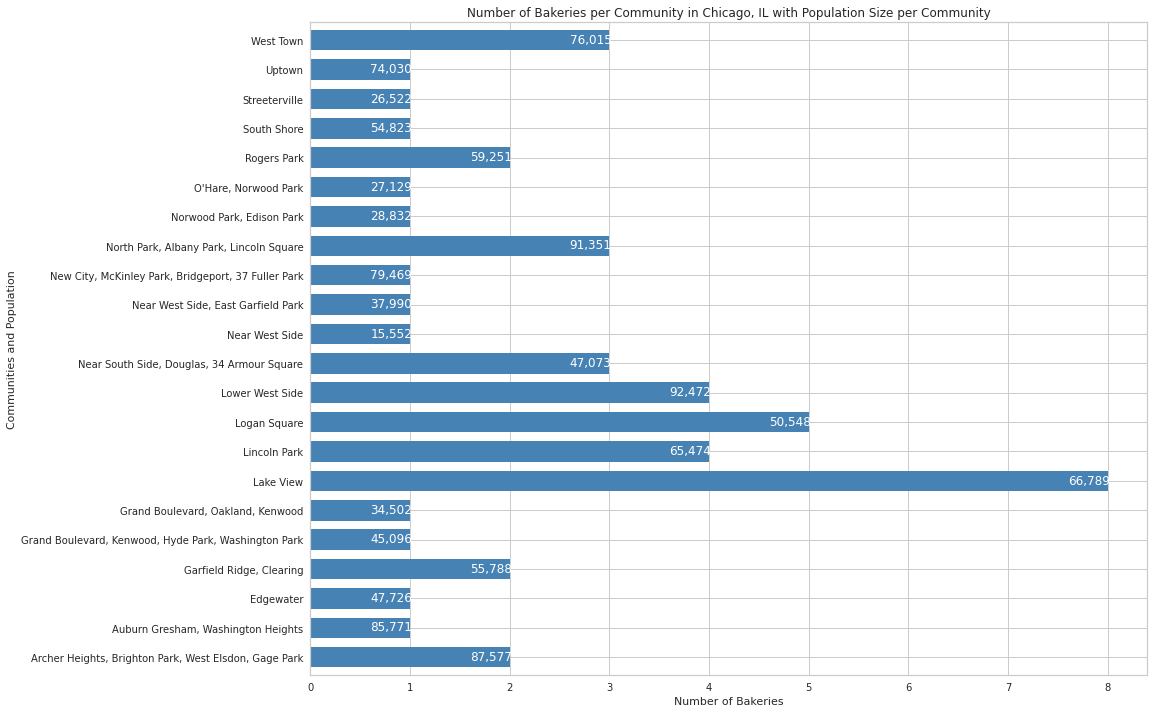

In [204]:
chicago_bakery_count_plot['Number of Bakeries per Community'].plot(kind='barh', figsize=(15, 12), color='steelblue', width=0.7)

plt.title('Number of Bakeries per Community in Chicago, IL with Population Size per Community')
plt.ylabel('Communities and Population')
plt.xlabel('Number of Bakeries')

for idx in range(chicago_bakery_count_plot.shape[0]): 
    label = format(int(chicago_bakery_count_plot.iloc[idx, 1]), ',')
    plt.annotate(label, xy=(chicago_bakery_count_plot.iloc[idx, 0]-0.4, idx - 0.10), color='white')

plt.show()

### 3.4. K-Means Clustering
Finally, we’ll use the information we have regarding venues and their popularity to group Chicago’s communities. This may help understand shopping behaviours that people in the community may have.

To determine the number of clusters we’ll run score elbow for KMeans clustering.

Next, we run KMeans machine learning algorithm, visualize and analyze the clusters.

In [130]:

chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

chicago_onehot['Community'] = chicago_venues['Community'] 

fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Community,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul F

In [131]:
chicago_onehot.shape

(3796, 320)

In [132]:
chicago_grouped = chicago_onehot.groupby('Community').mean().reset_index()
chicago_grouped

,Community,ATM,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recycling Facility,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul F

In [133]:
chicago_grouped.shape

(46, 320)

In [136]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [137]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['Community'] = chicago_grouped['Community']

for ind in np.arange(chicago_grouped.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

chicago_venues_sorted

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Archer Heights, Brighton Park, West Elsdon, Ga...",Mexican Restaurant,Discount Store,Sandwich Place,Grocery Store,Mobile Phone Shop,Donut Shop,Gas Station,Taco Place,Bank,Fast Food Restaurant
1,"Auburn Gresham, Washington Heights",Fast Food Restaurant,Lounge,Discount Store,Park,Pharmacy,Sandwich Place,Liquor Store,Seafood Restaurant,Cosmetics Shop,Train Station
2,Austin,Fast Food Restaurant,Park,Fried Chicken Joint,Golf Course,Grocery Store,Sandwich Place,Donut Shop,ATM,Liquor Store,Bus Station
3,"Austin, Humboldt Park",Mexican Restaurant,Park,Fast Food Restaurant,Grocery Store,Sandwich Place,Chinese Restaurant,Fried Chicken Joint,Donut Shop,Clothing Store,Wings Joint
4,Belmont Cragin,Mexican Restaurant,Donut Shop,Pharmacy,Sandwich Place,Discount Store,Pizza Place,Fast Food Restaurant,Cuban Restaurant,Fried Chicken Joint,Gas Station
5,Beverly,Park,BBQ Joint,Grocery Store,Sandwich Place,Ice Cream Shop,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cosmetics Shop
6,"Chatham, Avalon Park, Burnside",Discount Store,Fast Food Restaurant,Lounge,Intersection,Sandwich Place,Donut Shop,Chinese Restaurant,Bar,BBQ Joint,Train Station
7,Dunning,Pizza Place,Fast Food Restaurant,Cosmetics Shop,Park,Thai Restaurant,Currency Exchange,Video Store,Pharmacy,Donut Shop,Shoe Store
8,Edgewater,Coffee Shop,Café,Grocery Store,Gym,Restaurant,Ethiopian Restaurant,Beach,Bar,Burger Joint,Ice Cream Shop
9,Englewood,Fast Food Restaurant,Intersection,Gas Station,Sandwich Place,ATM,Restaurant,Nightclub,Food,Bookstore,Café


In [210]:
!pip install yellowbrick

Score elbow for KMeans clustering

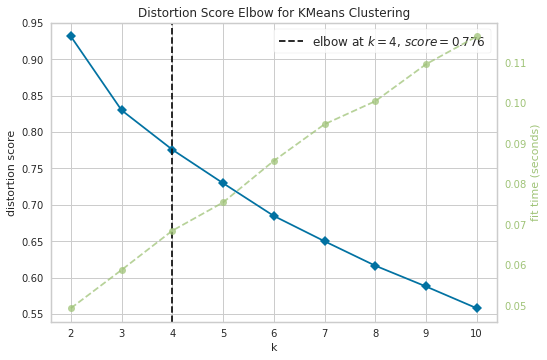

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [138]:
from yellowbrick.cluster import KElbowVisualizer
chicago_grouped_clustering = chicago_grouped.drop('Community', 1)
model = KElbowVisualizer(KMeans(), k=10)
model.fit(chicago_grouped_clustering)
model.show()

In [208]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 1, 2, 2, 0, 0, 2], dtype=int32)

In [140]:
chicago_data = df_zip_codes[df_zip_codes['City'] == 'Chicago'].reset_index(drop=True)
chicago_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = chicago_data

chicago_merged = chicago_merged.join(chicago_venues_sorted.set_index('Community'), on='Community')

chicago_merged.head()

,Zip Code,Community,Population,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60626,Rogers Park,59251,Chicago,IL,42.009731,-87.66938,0,Beach,Sandwich Place,Park,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Department Store,Supermarket
1,60660,Edgewater,47726,Chicago,IL,41.990631,-87.66670,0,Coffee Shop,Café,Grocery Store,Gym,Restaurant,Ethiopian Restaurant,Beach,Bar,Burger Joint,Ice Cream Shop
2,60640,Uptown,74030,Chicago,IL,41.973181,-87.66650,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant
3,60657,Lake View,66789,Chicago,IL,41.940832,-87.65852,0,Indian Restaurant,Bakery,Coffee Shop,Grocery Store,Sandwich Place,Ice Cream Shop,Sports Bar,Pizza Place,Pakistani Restaurant,Middle Eastern Restaurant
4,60610,Uptown,47513,Chicago,IL,41.898582,-87.63710,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant


In [141]:
chicago_merged

,Zip Code,Community,Population,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60626,Rogers Park,59251,Chicago,IL,42.009731,-87.66938,0,Beach,Sandwich Place,Park,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Department Store,Supermarket
1,60660,Edgewater,47726,Chicago,IL,41.990631,-87.66670,0,Coffee Shop,Café,Grocery Store,Gym,Restaurant,Ethiopian Restaurant,Beach,Bar,Burger Joint,Ice Cream Shop
2,60640,Uptown,74030,Chicago,IL,41.973181,-87.66650,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant
3,60657,Lake View,66789,Chicago,IL,41.940832,-87.65852,0,Indian Restaurant,Bakery,Coffee Shop,Grocery Store,Sandwich Place,Ice Cream Shop,Sports Bar,Pizza Place,Pakistani Restaurant,Middle Eastern Restaurant
4,60610,Uptown,47513,Chicago,IL,41.898582,-87.63710,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant
5,60613,Logan Square,50548,Chicago,IL,41.953256,-87.66290,0,Coffee Shop,Pizza Place,Café,Brewery,Bar,Ice Cream Shop,Bakery,Mexican Restaurant,Sports Bar,Italian Restaurant
6,60647,Logan Square,98769,Chicago,IL,41.921126,-87.70085,0,Coffee Shop,Pizza Place,Café,Brewery,Bar,Ice Cream Shop,Bakery,Mexican Restaurant,Sports Bar,Italian Restaurant
7,60625,"North Park, Albany Park, Lincoln Square",91351,Chicago,IL,41.971614,-87.70256,0,Coffee Shop,Bar,Grocery Store,Gym,Korean Restaurant,Bakery,Park,Sandwich Place,Mexican Restaurant,Pub
8,60614,Lincoln Park,65474,Chicago,IL,41.922682,-87.65432,0,Coffee Shop,Bar,Pizza Place,Park,Grocery Store,Italian Restaurant,Sushi Restaurant,Bakery,Liquor Store,Pharmacy
9,60651,"Austin, Humboldt Park",77583,Chicago,IL,41.901485,-87.74055,1,Mexican Restaurant,Park,Fast Food Restaurant,Grocery Store,Sandwich Place,Chinese Restaurant,Fried Chicken Joint,Donut Shop,Clothing Store,Wings Joint


In [143]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['City'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster Analysis

Of 52 bakeries, 11 show on the tip 10 list of the most popular venues per community. Of those 11, 9 are in the Cluster 1, represented with red color. The most popular venue in this cluster is Coffee Shop. In Cluster 2 (purple), there are 2 bakeries, and Cluster 3 and 4 has none. The most common type of venue in Cluster 2 are restaurants.

#### Cluster 1

In [144]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rogers Park,42.009731,-87.66938,0,Beach,Sandwich Place,Park,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Department Store,Supermarket
1,Edgewater,41.990631,-87.66670,0,Coffee Shop,Café,Grocery Store,Gym,Restaurant,Ethiopian Restaurant,Beach,Bar,Burger Joint,Ice Cream Shop
2,Uptown,41.973181,-87.66650,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant
3,Lake View,41.940832,-87.65852,0,Indian Restaurant,Bakery,Coffee Shop,Grocery Store,Sandwich Place,Ice Cream Shop,Sports Bar,Pizza Place,Pakistani Restaurant,Middle Eastern Restaurant
4,Uptown,41.898582,-87.63710,0,Coffee Shop,Hotel,Vietnamese Restaurant,Grocery Store,Pizza Place,Steakhouse,Italian Restaurant,Breakfast Spot,Mexican Restaurant,Restaurant
5,Logan Square,41.953256,-87.66290,0,Coffee Shop,Pizza Place,Café,Brewery,Bar,Ice Cream Shop,Bakery,Mexican Restaurant,Sports Bar,Italian Restaurant
6,Logan Square,41.921126,-87.70085,0,Coffee Shop,Pizza Place,Café,Brewery,Bar,Ice Cream Shop,Bakery,Mexican Restaurant,Sports Bar,Italian Restaurant
7,"North Park, Albany Park, Lincoln Square",41.971614,-87.70256,0,Coffee Shop,Bar,Grocery Store,Gym,Korean Restaurant,Bakery,Park,Sandwich Place,Mexican Restaurant,Pub
8,Lincoln Park,41.922682,-87.65432,0,Coffee Shop,Bar,Pizza Place,Park,Grocery Store,Italian Restaurant,Sushi Restaurant,Bakery,Liquor Store,Pharmacy
10,Lake View,41.991381,-87.70378,0,Indian Restaurant,Bakery,Coffee Shop,Grocery Store,Sandwich Place,Ice Cream Shop,Sports Bar,Pizza Place,Pakistani Restaurant,Middle Eastern Restaurant


In [192]:
clust_1 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
clust_1 = clust_1.apply(pd.Series.value_counts, axis=0)

try:
    sum_coffee_shops = clust_1.loc['Coffee Shop'].sum()
except:
    print('There are no Coffee Shops in this cluster')
else:
    print(f'Number of Coffee Shops: {sum_coffee_shops}')
    
try:
    sum_bakeries = clust_1.loc['Bakery'].sum()
except:
    print('There are no Bakeries in this cluster')
else:
    print(f'Number of Bakeries: {sum_bakeries}')

Number of Coffee Shops: 19.0
Number of Bakeries: 9.0


#### Cluster 2

In [145]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Austin, Humboldt Park",41.901485,-87.74055,1,Mexican Restaurant,Park,Fast Food Restaurant,Grocery Store,Sandwich Place,Chinese Restaurant,Fried Chicken Joint,Donut Shop,Clothing Store,Wings Joint
11,Belmont Cragin,41.921431,-87.75415,1,Mexican Restaurant,Donut Shop,Pharmacy,Sandwich Place,Discount Store,Pizza Place,Fast Food Restaurant,Cuban Restaurant,Fried Chicken Joint,Gas Station
13,"North Lawndale, South Lawndale",41.850232,-87.71800,1,Mexican Restaurant,Bank,Fast Food Restaurant,Pizza Place,Pharmacy,Mobile Phone Shop,Sandwich Place,Taco Place,Dessert Shop,Seafood Restaurant
16,"Portage Park, Irving Park",41.946431,-87.74576,1,Bar,Sandwich Place,Discount Store,Coffee Shop,Chinese Restaurant,Mexican Restaurant,South American Restaurant,Gym,Donut Shop,Pharmacy
24,"West Lawn, Chicago Lawn",41.777482,-87.71155,1,Mexican Restaurant,Pizza Place,Fast Food Restaurant,Discount Store,Donut Shop,Pharmacy,Park,Sandwich Place,Grocery Store,Deli / Bodega
25,Lower West Side,41.850532,-87.66990,1,Mexican Restaurant,Bar,Pizza Place,Diner,Bakery,Latin American Restaurant,Park,Grocery Store,Taco Place,Italian Restaurant
31,"Archer Heights, Brighton Park, West Elsdon, Ga...",41.809299,-87.71050,1,Mexican Restaurant,Discount Store,Sandwich Place,Grocery Store,Mobile Phone Shop,Donut Shop,Gas Station,Taco Place,Bank,Fast Food Restaurant
36,"New City, McKinley Park, Bridgeport, 37 Fuller...",41.814283,-87.65282,1,Pizza Place,Bar,Baseball Field,Donut Shop,American Restaurant,Pharmacy,Brewery,Discount Store,Mexican Restaurant,Fast Food Restaurant
38,"Lincoln Square, North Park, Albany Park",41.744600,-87.71188,1,Park,Ice Cream Shop,Pizza Place,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Fried Chicken Joint,Mexican Restaurant,Intersection,Pharmacy
43,South Deering,41.719973,-87.55570,1,Mexican Restaurant,Harbor / Marina,Intersection,Pharmacy,Fish Market,Grocery Store,Sandwich Place,Park,Bank,Discount Store


In [193]:
clust_2 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
clust_2 = clust_2.apply(pd.Series.value_counts, axis=0)
sum_coffee_shops = clust_2.loc['Coffee Shop'].sum()

try:
    sum_coffee_shops = clust_2.loc['Coffee Shop'].sum()
except:
    print('There are no Coffee Shops in this cluster')
else:
    print(f'Number of Coffee Shops: {sum_coffee_shops}')
    
try:
    sum_bakeries = clust_2.loc['Bakery'].sum()
except:
    print('There are no Bakeries in this cluster')
else:
    print(f'Number of Bakeries: {sum_bakeries}')

Number of Coffee Shops: 1.0
Number of Bakeries: 2.0


#### Cluster 3

In [146]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,South Shore,41.761734,-87.57072,2,Fried Chicken Joint,Discount Store,Chinese Restaurant,Seafood Restaurant,Sandwich Place,Bank,Café,Cosmetics Shop,Coffee Shop,Fast Food Restaurant
21,Austin,41.881331,-87.75671,2,Fast Food Restaurant,Park,Fried Chicken Joint,Golf Course,Grocery Store,Sandwich Place,Donut Shop,ATM,Liquor Store,Bus Station
22,"Grand Boulevard, Oakland, Kenwood",41.819833,-87.61269,2,Beach,Park,Art Gallery,BBQ Joint,Fried Chicken Joint,Sandwich Place,Grocery Store,Restaurant,Convenience Store,Fast Food Restaurant
27,West Englewood,41.776633,-87.66854,2,Fast Food Restaurant,Discount Store,Cosmetics Shop,Park,Sandwich Place,Donut Shop,Liquor Store,Grocery Store,Chinese Restaurant,Seafood Restaurant
28,"West Garfield Park, East Garfield Park",41.879365,-87.72199,2,Fast Food Restaurant,Fried Chicken Joint,Train Station,Discount Store,Park,Sandwich Place,Food,Cosmetics Shop,American Restaurant,Diner
30,Englewood,41.776983,-87.64040,2,Fast Food Restaurant,Intersection,Gas Station,Sandwich Place,ATM,Restaurant,Nightclub,Food,Bookstore,Café
32,"Chatham, Avalon Park, Burnside",41.744834,-87.60444,2,Discount Store,Fast Food Restaurant,Lounge,Intersection,Sandwich Place,Donut Shop,Chinese Restaurant,Bar,BBQ Joint,Train Station
33,"Auburn Gresham, Washington Heights",41.740483,-87.65282,2,Fast Food Restaurant,Lounge,Discount Store,Park,Pharmacy,Sandwich Place,Liquor Store,Seafood Restaurant,Cosmetics Shop,Train Station
39,"Roseland, Pullman",41.695434,-87.62255,2,Sandwich Place,Fast Food Restaurant,Discount Store,Park,Train Station,Food,Chinese Restaurant,Fried Chicken Joint,Bank,BBQ Joint
40,Beverly,41.696433,-87.65993,2,Park,BBQ Joint,Grocery Store,Sandwich Place,Ice Cream Shop,Café,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Cosmetics Shop


In [194]:
clust_3 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
clust_3 = clust_3.apply(pd.Series.value_counts, axis=0)

try:
    sum_coffee_shops = clust_3.loc['Coffee Shop'].sum()
except:
    print('There are no Coffee Shops in this cluster')
else:
    print(f'Number of Coffee Shops: {sum_coffee_shops}')
    
try:
    sum_bakeries = clust_3.loc['Bakery'].sum()
except:
    print('There are no Bakeries in this cluster')
else:
    print(f'Number of Bakeries: {sum_bakeries}')


Number of Coffee Shops: 2.0
There are no Bakeries in this cluster


#### Cluster 4

In [147]:
chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]

,Community,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,Hegewisch,41.655423,-87.55365,3,Bar,Pizza Place,Harbor / Marina,Pet Store,State / Provincial Park,Canal Lock,Mexican Restaurant,Chinese Restaurant,Greek Restaurant,Park


## 4. Results and Discussion <a name="results"></a>

There are 52 bakeries in Chicago and 11 of those show as popular venues in cluster of Chicago communities.

Communities Auber Gresham, Washington Heights, Uptown and New City has only 1 bakery and population with around 80,000. The highest concentration of bakeries is in Lake View, 8 and with population of around 66,000 those bakeries are in the business where they may serve around 8,000 people each.

Analysing Cluster, Cluster 1 ha significant number of bakeries comparing with other clusters, 9; with Cluster 2 of 2 and Cluster 3 and 4 has no bakeries as poplar venues. It is unclear what is the reason behind this. Cluster 1 has Coffee Shop as the most popular venue. Coffee shops may be indirect competitor to the bakeries since some of the complimentary products to the coffee they are selling are bakery products. On the other hand, depending on the ownership of those coffee shops, they can also be potential buyers of bakery products, so it may help new bakery grow the business. More studies are required to understand this phenomenon.


## 4. Conclusion <a name="conclusion"></a>

It is difficult to conclude where would be the best location to open a bakery in Chicago. We can argue that going to the communities that don’t have many bakeries would a good choice since there is less of direct competition.

However, more analysis is needed to understand not just popular venues but also business in the area and how they may affect a new bakery business. Also, understanding cost to rent or buy the venue for the new bakery is very important since it can affect the cost of the products the bakery is selling. Last but not least bakery product cost analysis is needed to understand profit margins and what affect they may have on the new bakery business.
